In [10]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression 
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error



In [3]:
#Defining Datasets

df1 = pd.read_csv('uszips_2.csv')

df2 = pd.read_csv('us_congestion_2016_2022_sample_2m.csv', usecols=['Severity', 'Start_Lat', 'Start_Lng', 'StartTime', 'EndTime', 'Distance(mi)', 'DelayFromTypicalTraffic(mins)', 'DelayFromFreeFlowSpeed(mins)'])
            
df2['Year'] = df2['StartTime'].str.slice(0, 4).astype('Int64')  # allows NaNs

df2['Month'] = df2['StartTime'].str.slice(5,7).astype('Int64')

df2.drop(['StartTime', 'EndTime'], axis=1, inplace=True)

df2.head()


,Severity,Start_Lat,Start_Lng,Distance(mi),DelayFromTypicalTraffic(mins),DelayFromFreeFlowSpeed(mins),Year,Month
0,2,39.191032,-120.819740,1.40,2.58,2.60,2016,12
1,0,41.736015,-87.721565,0.73,0.42,1.00,2018,11
2,0,32.519043,-93.741096,1.80,1.00,2.00,2021,2
3,0,40.730564,-74.001709,1.42,1.00,2.00,2020,11
4,1,33.758331,-118.238533,2.60,4.90,6.92,2017,8


In [4]:
#Zip Code to Long/Lat Method

def zip_to_long_lat(zipcode):
    match = df1[df1['zip'] == zipcode]
    if match.empty:
        print(f"No match found for zip code {zipcode}")
        return
    lat = match['lat'].values[0]
    long = match['lng'].values[0]
    coord = (lat, long)
    print(f"The city for zip code {zipcode} is: {coord}")
    return coord

#Predicting new points method
def predict_delay(lat, lng, model, feature_names, month_predict):
    row = pd.Series({col: np.nan for col in feature_names})
    row['Start_Lat'] = lat
    row['Start_Lng'] = lng
    row['Year'] = datetime.now().year
    row['Month'] = month_predict
    return model.predict(pd.DataFrame([row]))[0]

In [5]:
X = df2.drop(['DelayFromFreeFlowSpeed(mins)'], axis=1)
y = df2['DelayFromFreeFlowSpeed(mins)']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [6]:
# Train the model
rf = RandomForestRegressor(
    n_estimators=300,
    max_depth=30,
    min_samples_split=5,
    min_samples_leaf=1,
    max_features='sqrt',
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=30, max_features='sqrt', min_samples_split=5,
                      n_estimators=300, n_jobs=-1, random_state=42)

In [7]:
# Predict and evaluate
y_pred = rf.predict(X_test)
y_pred = np.clip(y_pred, 0, None) 
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"Random Forest RMSE: {rmse:.4f}")

MAE: 0.5904219940204606
MSE: 1.3133939481678931
Random Forest RMSE: 1.1460


In [8]:
#Logic

zip_code = int(input('Please Enter the Zip Code: '))

coord = zip_to_long_lat(zip_code)
delay_list = []

feature_cols = df2.drop(columns=['DelayFromFreeFlowSpeed(mins)']).columns
for month in range(1,13):
    delay = predict_delay(coord[0], coord[1], rf, feature_cols, month)
    delay_list.append(delay)
    print(f"Predicted Delay: {delay:.2f} minutes")

The city for zip code 75035 is: (33.15814, -96.7734)
Predicted Delay: 1.63 minutes
Predicted Delay: 1.45 minutes
Predicted Delay: 1.48 minutes
Predicted Delay: 1.53 minutes
Predicted Delay: 1.44 minutes
Predicted Delay: 1.51 minutes
Predicted Delay: 1.51 minutes
Predicted Delay: 1.55 minutes
Predicted Delay: 1.46 minutes
Predicted Delay: 1.48 minutes
Predicted Delay: 1.54 minutes
Predicted Delay: 1.51 minutes


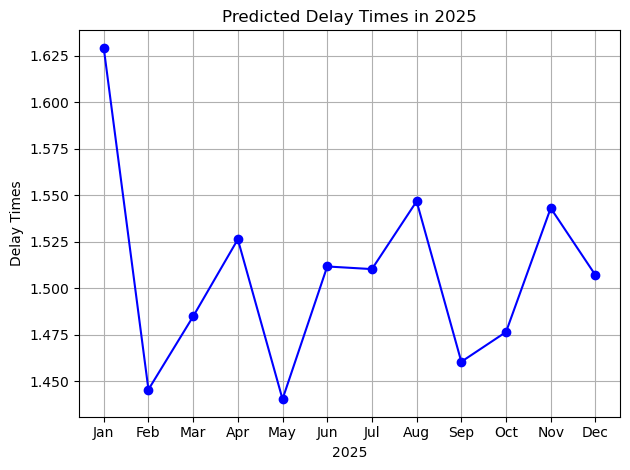

In [13]:
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

plt.figure()
plt.plot(months, delay_list, marker='o', linestyle='-', color='b')
plt.title(f"Predicted Delay Times in {datetime.now().year}")
plt.xlabel(f'{datetime.now().year}')
plt.ylabel("Delay Times")
plt.grid(True)
plt.tight_layout()
plt.show()